# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). The emails used to train this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). 

In [25]:
from bs4 import BeautifulSoup
import email
import joblib
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import string

## 1 Preprocessing

The two functions below will aid in the processing of the emails when the are used with our model. The first fucntion, `process_email`, take the text of the email and removes the header, HTML, punctuation, etc. The second function, `stemmed_words`, calls `process_email` on the text and then runs a stemmer on the words in the email. `stemmed_words` will be our actual analyzer function for `CountVectorizer`, as you can see below.

In [4]:
def process_email(txt):
    """
    Takes an email message and cleans it up for use with CountVectorizer().
    """
    if (type(txt) == bytes):
        msg_email = email.message_from_bytes(txt)
    else:
        msg_email = email.message_from_string(txt)
        
    # Only use the message body
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = re.sub('\n', ' ', msg)
    msg = re.sub('\t', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = re.sub('[0-9]+', 'number', msg)
    msg = re.sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = re.sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = re.sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    msg = msg.translate(table)
    return msg

stemmer = PorterStemmer()
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()

def stemmed_words(doc):
    doc = process_email(doc)
    return (stemmer.stem(w) for w in analyzer(doc))

### 1.1 Load the text files
`load_files` is a nice function for loading large amounts of data. I have the spam emails in `./data/spam` and the ham emails in `./data/ham`. `load_files` automatically classifies the documents based on which folder they are in. When I downloaded the data sets I sorted them based on their labels given by the data set's curator. The emails themselves are stored in the `.data` object with the labels stored in the `.target` object.

In [5]:
from sklearn.datasets import load_files

In [6]:
emails = load_files('data/')

In [7]:
emails.target_names

['ham', 'spam']

In [8]:
emails.target

array([0, 1, 0, ..., 0, 0, 0])

### 1.2 Split data into train and test sets
`train_test_split` shuffles the data by default and splits the data into training and test sets, with 75% of the data in the training set, and 25% in the test set.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(emails.data, emails.target)

Here's one example of an email before and after it is processed:

In [11]:
X_train[0]

b'From georgiana_sprott@aemail4u.com  Mon Jun 24 17:52:21 2002\nReturn-Path: georgiana_sprott@aemail4u.com\nDelivery-Date: Sun Jun  2 16:48:25 2002\nReceived: from mandark.labs.netnoteinc.com ([213.105.180.140]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g52FmOO32202 for\n    <jm@jmason.org>; Sun, 2 Jun 2002 16:48:25 +0100\nReceived: from smtp.easydns.com (smtp.easydns.com [205.210.42.30]) by\n    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with ESMTP id g52FmN724287 for\n    <jm@netnoteinc.com>; Sun, 2 Jun 2002 16:48:23 +0100\nReceived: from aemail4u.com (unknown [203.250.250.21]) by smtp.easydns.com\n    (Postfix) with SMTP id 5BE662DF25 for <jm@netnoteinc.com>; Sun,\n    2 Jun 2002 11:46:44 -0400 (EDT)\nReceived: from 109.34.246.77 ([109.34.246.77]) by rly-xw01.mx.aol.com with\n    esmtp; 03 Jun 2002 00:55:31 -0900\nReply-To: <georgiana_sprott@aemail4u.com>\nMessage-Id: <027d82a01d7e$7657e4b0$5ce17ed7@afnqor>\nFrom: <georgiana_sprott@aemail4u.com>\nTo: Member07@no.hos

Here it is after processing, before stemming:

In [12]:
process_email(X_train[0])

'public announcement  the new domain names are finally available to the general public at discount prices now you can register one of the exciting new biz or info domain names as well as the original com and net names for just dollarnumbernumber these brand new domain extensions were recently approved by icann and have the same rights as the original com and net domain names the biggest benefit is ofcourse that the biz and info domain names are currently more available ie it will be much easier to register an attractive and easytoremember domain name for the same price  visit httpaddr today for more info   register your domain name today for just dollarnumbernumber at httpaddr registration fees include full access to an easytouse control panel to manage your domain name in the future   sincerely   domain administrator affordable domains   to remove your email address from further promotional mailings from this company click here httpaddr number   numberreyonumbernumberzkcvnumbertdvrnum

Here we test out our `CountVectorizer` that calls our analyzer, stemming the words and representing whether or not a word is present by a `0` or `1` (`binary` = True). This is one version of the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model). We could also represent the actual count, but here we only will indicate if a word is prsent. In the end our vocabulary list will be built up from all of the emails and sorted by word frequency. We'll only keep the most frequent words in our model.

In [17]:
vect = CountVectorizer(decode_error='ignore', binary=True, analyzer=stemmed_words)
X_tmp = vect.fit_transform([X_train[0]])
vect.get_feature_names()[:10]

['access',
 'address',
 'administr',
 'afford',
 'an',
 'and',
 'announc',
 'approv',
 'are',
 'as']

The following shows a `1` for every feature, since our vocabulary list only comes from the single point in our data set. So, obviously all words found in this email are present in this email. Again, later our vocabulary list will be built from the entire training set and then applied to each email.

In [19]:
X_tmp.toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]], dtype=int64)

## 2 Support Vector Machine

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

### 2.1 Pipeline construction

First we build a `Pipeline` so that every point in the data set (*i.e.*, every email) is passed through the `CountVectorizer` object first and transformed to a bag-of-words representation. We are only going to keep the 2000 most frequently occurring words in the training set, but we could adjust this as a hyperparameter if we desired. Some of the emails have some decoding issues (only a few) so we'll just ignore those. You can see once again we're specifying `binary=True`, meaning we only are counting if a vocabulary word is in the email, not the number of occurrences. We specify the `analyzer` which we made above which is responsible for *both* the preprocessing and tokenization of the words.

After emails are processed by `CountVectorizer` they are then fed into `SVC`, the support vector classifer. We are specifying a linear kernel here, but we could easily make that a hyper parameter to do a grid search on below.

In [47]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=2000, 
                             decode_error='ignore',
                             binary=True,
                             analyzer=stemmed_words)),
    ('svc', SVC(kernel='linear')),
])

### 2.2 Grid search
Here we construct a grid search over the `C` parameter used with the support vector classifer. This is the regularization parameter, also known as the penalty parameter. Smaller values mean more regularization in this case. We run the search on the training set alone and save the model to disk.

This grid search also does cross-validation, meaning the data set is split up into two parts, which will become our new training and test sets for this purpose. I'm using five-fold CV, meaning 4/5 of the data is going to be a training set, and the other 1/5 is the test set. For each set of hyperparameters we do this five times, since the data will be split up in five different ways. In the end we'll find the value of `C` that produces the best estimator and that will be used in our final test with the original test set.

In [49]:
tuned_parameters = [{'svc__C': np.logspace(-2,2,5)}]
clf = GridSearchCV(pipeline, param_grid=tuned_parameters, 
                   scoring="f1", return_train_score=True,
                   verbose=10, n_jobs=3, cv=5)
clf.fit(X_train, y_train)
joblib.dump(clf, 'clf.gz')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.9023136246786633, total= 1.4min
[CV] svc__C=0.01 .....................................................
[CV] ............. svc__C=0.01, score=0.858034321372855, total= 1.3min
[CV] svc__C=0.01 .....................................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.5min


[CV] ............ svc__C=0.01, score=0.8593508500772797, total= 1.4min
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.8682170542635658, total= 1.4min
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.9010416666666666, total= 1.5min
[CV] svc__C=0.1 ......................................................
[CV] .............. svc__C=0.1, score=0.904040404040404, total= 1.3min
[CV] svc__C=0.1 ......................................................
[CV] .............. svc__C=0.1, score=0.924066924066924, total= 1.3min
[CV] svc__C=0.1 ......................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  7.0min


[CV] ............. svc__C=0.1, score=0.8978562421185371, total= 1.2min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9238709677419354, total= 1.4min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9093231162196679, total= 1.2min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.8964646464646465, total= 1.3min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9234760051880674, total= 1.4min
[CV] svc__C=1.0 ......................................................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  9.8min


[CV] .............. svc__C=1.0, score=0.922680412371134, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.8908629441624365, total= 1.3min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.8987341772151899, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.8964646464646465, total= 1.2min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9232769830949284, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=10.0, score=0.922680412371134, total= 1.4min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=10.0, score=0.8955974842767296, total= 1.3min
[CV] svc__C=100.0 ....................................................


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 15.7min


[CV] ............ svc__C=10.0, score=0.9035532994923858, total= 1.5min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.8964646464646465, total= 1.3min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.9232769830949284, total= 1.4min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=100.0, score=0.922680412371134, total= 1.2min


[Parallel(n_jobs=3)]: Done  23 out of  25 | elapsed: 19.2min remaining:  1.7min


[CV] ........... svc__C=100.0, score=0.8955974842767296, total= 1.3min
[CV] ........... svc__C=100.0, score=0.9035532994923858, total= 1.3min


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 20.3min finished


['clf.gz']

### 2.3 Validation curve

Below we plot the validation curve, showing the average train and test scores from the cross validation as a function of the penalty parameter `C`. As you can see there is a peak in the test score at `C=0.1`. Any value greater than that means we would be overfitting, and values lower than that are underfitting.

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score

In [20]:
clf = joblib.load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

In [21]:
clf.best_params_

{'svc__C': 0.1}

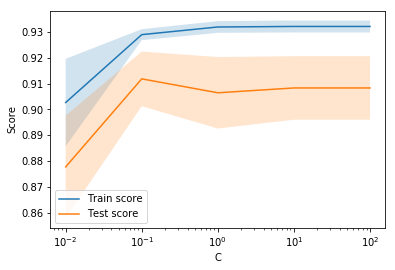

In [27]:
results.plot('param_svc__C', 'mean_train_score', label='Train score')
results.plot('param_svc__C', 'mean_test_score', label='Test score', ax=plt.gca())
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

## 3 Test set evaluation

### 3.1 Classification report

Precision: 

$ P = \frac{T_{p}}{T_{p} + F_{p}} $

Recall:

$ R = \frac{T_{p}}{T_{p} + F_{n}} $

F1 score:

$ F1 = 2\frac{PR}{P+R}$

In [55]:
y_pred = clf.predict(X_test)

In [57]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.929


In [58]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.912


In [56]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97      1759
          1       0.86      0.97      0.91       579

avg / total       0.96      0.95      0.95      2338



### 3.2 Precision-recall curve

Precision-recall curves show the changes in precision and recall for different probability thresholds. That is, when we predict whether or not an email is spam, we get a probabliity. We could classify an email to be spam if `p >= 0.5` and not spam otherwise, but we can change that threshold.

Average precision:

$ AP = \sum_{n}(R_{n} - R_{n-1})P_{n} $

In [36]:
average_precision = average_precision_score(y_test, y_score)

Area under the precision-recall curve using the trapezoidal rule.

In [37]:
auc_score = roc_auc_score(y_test, y_score)

In [38]:
y_score = clf.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

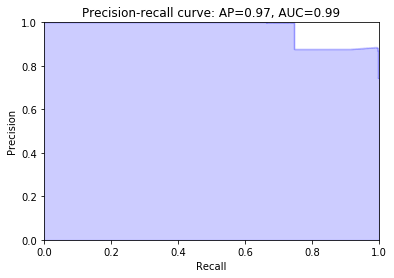

In [39]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}, AUC={1:0.2f}'.format(average_precision, auc_score))
plt.show()

## 4 Top predictors of spam

Shown below, there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to in these specific emails. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set, or we can adjust `CountVectorizer` in the pipeline (or do a grid search over some additional hyperparameters).

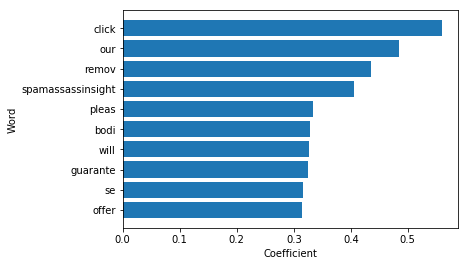

In [59]:
def plot_top(coef, names, n=10):
    coef_argsorted = np.argsort(coef)
    feature_names_array = np.array(names)
    words = []
    values = []
    for i in range(-n,0):
        words.append(names[coef_argsorted[i]])
        values.append(coef[coef_argsorted[i]])

    y = np.arange(n)
    plt.barh(y, values)
    plt.yticks(y, words)
    plt.xlabel('Coefficient')
    plt.ylabel('Word')
    plt.show()
    
plot_top(clf.best_estimator_.named_steps['svc'].coef_.toarray()[0], 
         clf.best_estimator_.named_steps['vect'].get_feature_names())